In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from keras import load_model

# Cargar el modelo
model = load_model('model/model_palabras1.keras')

# Lista de palabras
classes = ['abrazar', 'casa', 'codo', 'cortar', 'disculpar', 'dormir', 'enfermo', 'hora', 'mio', 'quien', 'tomar', 'trabajo', 'tu', 'yo', 'zapato']

# Iniciar la captura de video
cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()
    if not ret:
        break

    H, W, _ = frame.shape
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        hand_data = []  # Para almacenar datos de cada mano
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

            # Obtener las coordenadas de la mano
            single_hand_data = []
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                single_hand_data.append(x - min(x_))
                single_hand_data.append(y - min(y_))

            hand_data.append(single_hand_data)

        # Asegurar que haya datos para dos manos
        if len(hand_data) == 1:
            hand_data.append([0] * 42)  # Rellenar con ceros para la segunda mano

        # Combinar datos de ambas manos
        data_aux = hand_data[0] + hand_data[1]

        # Predecir la palabra
        probabilities = model.predict(np.asarray([data_aux]))[0]

        if np.max(probabilities) > 0.8:  # Umbral de confianza
            prediction = np.argmax(probabilities)
            predicted_word = classes[prediction]
        else:
            predicted_word = "No detectado"

        # Dibujar el área de detección y la predicción en el marco
        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10
        x2 = int(max(x_) * W) + 10
        y2 = int(max(y_) * H) + 10

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
        cv2.putText(frame, predicted_word, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

    # Mostrar el video en tiempo real
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


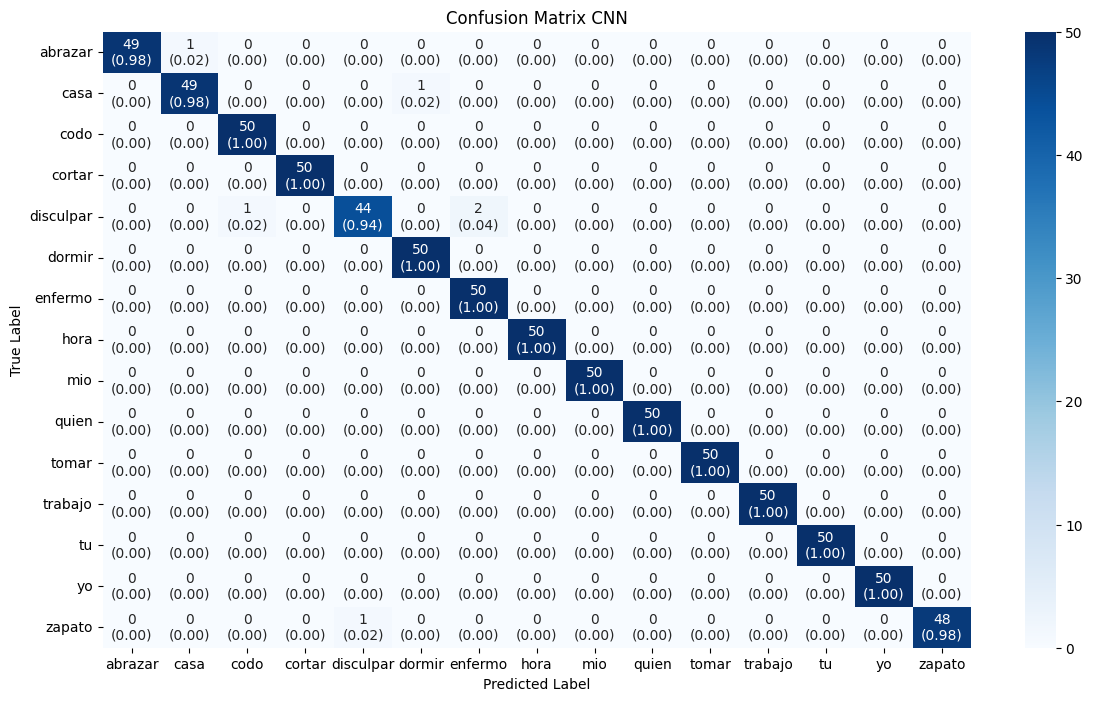

Classification Report:
              precision    recall  f1-score   support

     abrazar       1.00      0.98      0.99        50
        casa       0.98      0.98      0.98        50
        codo       0.98      1.00      0.99        50
      cortar       1.00      1.00      1.00        50
   disculpar       0.98      0.94      0.96        47
      dormir       0.98      1.00      0.99        50
     enfermo       0.96      1.00      0.98        50
        hora       1.00      1.00      1.00        50
         mio       1.00      1.00      1.00        50
       quien       1.00      1.00      1.00        50
       tomar       1.00      1.00      1.00        50
     trabajo       1.00      1.00      1.00        50
          tu       1.00      1.00      1.00        50
          yo       1.00      1.00      1.00        50
      zapato       1.00      0.98      0.99        49

    accuracy                           0.99       746
   macro avg       0.99      0.99      0.99       746
wei

In [8]:
import pickle
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo guardado en formato .h5
model = load_model('model/model_palabras1.keras')

# Diccionario para mapear índices a letras
index_to_letter = {0: 'abrazar', 1: 'casa', 2: 'codo', 3: 'cortar', 4: 'disculpar', 5: 'dormir', 6: 'enfermo', 7: 'hora', 8: 'mio', 9: 'quien', 10: 'tomar', 11: 'trabajo', 12: 'tu', 13: 'yo', 14: 'zapato'}

# Cargar los datos de prueba desde el archivo .pickle
data_dict = pickle.load(open('data/data_palabras_test1.pickle', 'rb'))

# Convertir los datos y etiquetas a arrays de numpy
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

# Convertir etiquetas de texto a números usando LabelEncoder
label_encoder = LabelEncoder()
y_true_classes = label_encoder.fit_transform(labels)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(data)

# Convertir predicciones a clases (etiquetas) si es necesario
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred.astype(int)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix_normalized = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')

# Crear la matriz combinada
combined_matrix = np.zeros_like(conf_matrix, dtype=np.float32).astype(str)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        combined_matrix[i, j] = f"{conf_matrix[i, j]}\n({conf_matrix_normalized[i, j]:.2f})"

# Configuración de la visualización de la matriz combinada
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix, annot=combined_matrix, fmt='', cmap='Blues', xticklabels=['abrazar', 'casa', 'codo', 'cortar', 'disculpar', 'dormir', 'enfermo', 'hora', 'mio', 'quien', 'tomar', 'trabajo', 'tu', 'yo','zapato'], yticklabels=['abrazar', 'casa', 'codo', 'cortar', 'disculpar', 'dormir', 'enfermo', 'hora', 'mio', 'quien', 'tomar', 'trabajo', 'tu', 'yo','zapato'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN')
plt.show()

# Reporte de Clasificación
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['abrazar', 'casa', 'codo', 'cortar', 'disculpar', 'dormir', 'enfermo', 'hora', 'mio', 'quien', 'tomar', 'trabajo', 'tu', 'yo','zapato']))

<a id="section1"></a>
# <font color="#004D7F">Cargamos las imágenes</font>

In [11]:
#Definimos la ruta de las imágenes
import pathlib
ruta = pathlib.Path("../dataset-test")

In [ ]:
#Cargamos las imágenes
import tensorflow as tf 
batch_size = 32
width_shape = 200
height_shape = 200

data_test = tf.keras.preprocessing.image_dataset_from_directory(
  ruta,
  seed=7,
  image_size=(height_shape, width_shape),
  batch_size=batch_size)

In [ ]:
#Leemos las categorías de las imágenes
categorias =data_test.class_names
categorias

In [ ]:
#Contamos en número de imágenes por clase
conteoimagenes=[]
for carpeta in ruta.iterdir(): 
  conteos = len(list(pathlib.Path(str(carpeta)).glob('*.*')))
  conteoimagenes.append(conteos)
print("Imágenes ", categorias[0], ": " ,conteoimagenes[0])
print("Imágenes ", categorias[1], ": " ,conteoimagenes[1])
print("Imágenes ", categorias[2], ": " ,conteoimagenes[2])
print("Imágenes ", categorias[3], ": " ,conteoimagenes[3])
print("Imágenes ", categorias[4], ": " ,conteoimagenes[4])
print("Imágenes ", categorias[5], ": " ,conteoimagenes[5])
print("Imágenes ", categorias[6], ": " ,conteoimagenes[6])
print("Imágenes ", categorias[7], ": " ,conteoimagenes[7])
print("Imágenes ", categorias[8], ": " ,conteoimagenes[8])
print("Imágenes ", categorias[9], ": " ,conteoimagenes[9])
print("Imágenes ", categorias[10], ": " ,conteoimagenes[10])
print("Imágenes ", categorias[11], ": " ,conteoimagenes[11])
print("Imágenes ", categorias[12], ": " ,conteoimagenes[12])
print("Imágenes ", categorias[13], ": " ,conteoimagenes[13])
print("Imágenes ", categorias[14], ": " ,conteoimagenes[14])
print("Imágenes ", categorias[15], ": " ,conteoimagenes[15])
print("Imágenes ", categorias[16], ": " ,conteoimagenes[16])
print("Imágenes ", categorias[17], ": " ,conteoimagenes[17])
print("Imágenes ", categorias[18], ": " ,conteoimagenes[18])
print("Imágenes ", categorias[19], ": " ,conteoimagenes[19])

In [ ]:
#Visualizamos 1 imagen
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
for images, labels in data_test.take(1):
  for i in range(15):
    ax = plt.subplot(3,5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(categorias[labels[i]])
    plt.axis("off")